In [1]:
TEST = True

Check which hyper-parameters are required by TransE:

In [2]:
from datetime import datetime
from pykeen.kge_models import TransE
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'corrupt_relations',
 'scoring_function',
 'normalization_of_entities']

Train and evaluate Region (provide test set):
* Define the path to our test set: **test_set_path**
* Define the path to our the negative test set: **neg_test_path** in case of triple classfication evaluation
* Define whether you want to compute the metrics (mean rank and hits@k) in raw or in a filtered setting: **filter_negative_triples**

In [3]:
config = dict(
    metrics                     = [],    
    training_set_path           = '../../../data/fb15k-237/valid_200.tsv',
    test_set_path               = '../../../data/fb15k-237/valid_200.tsv',
    #neg_test_set_path           = '../../../data/fb15k-237/valid_neg.tsv',
    mapping_path                = '../../../data/fb15k-237/',
    
    execution_mode              = 'Training_mode',
    random_seed                 = 2,
    kg_embedding_model_name     = 'TransE',
    loss_type                   = 'MRL',
    embedding_dim               = 50,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 1,
    es_metric                   = 'custom',
    
    learning_rate               = 0.01,
    num_epochs                  = 1000 if not TEST else 1000,  
    batch_size                  = 2**11,
    test_batch_size             = 2**16,
    filter_negative_triples     = False,
    corrupt_relations           = False,
    neg_factor                  = 1,
    preferred_device            = 'cpu'
)

In [4]:
time = datetime.now()
stamp = "{:04d}{:2d}{:2d}-{:2d}{:2d}".format(time.year, time.month, time.day, time.hour, time.minute)
stamp

'20191028-1612'

In [5]:
output_directory = '../../../models/FB15k237_TransE_{}_dim{}_loss-{}_lr{}_margin{}_epochs{}_bs{}_esmetric-{}/'.format(
    stamp, 
    config['embedding_dim'],
    config['loss_type'],
    str(config['learning_rate']).replace('.',''),
    config['margin_loss'],
    config['num_epochs'],
    config['batch_size'],
    config['es_metric']
)
output_directory

'../../../models/FB15k237_TransE_20191028-1612_dim50_loss-MRL_lr001_margin1_epochs1000_bs2048_esmetric-custom/'

In [6]:
if TEST:
    output_directory = '../../../models/test/'

In [7]:
import logging
import os
import sys
import time
import pykeen

In [8]:
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('pykeen').setLevel(logging.DEBUG)

In [9]:
print(sys.version)

3.6.5 (default, Mar 31 2018, 19:45:04) [GCC]


In [10]:
print(time.asctime())

Mon Oct 28 16:12:43 2019


In [11]:
print(pykeen.get_version())

0.0.26-dev


## Train and evaluate TransE:

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

In [14]:
# my
results = pykeen.run(
    config=config,
    output_directory=output_directory,
)

DEBUG:pykeen.utilities.pipeline:Reading the label mappings...
/mounts/Users/student/speranskaya/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
INFO:pykeen.utilities.pipeline:-------------Train KG Embeddings-------------
DEBUG:pykeen.utilities.train_utils:****running model on cpu****


{'metrics': [], 'training_set_path': '../../../data/fb15k-237/valid_200.tsv', 'test_set_path': '../../../data/fb15k-237/valid_200.tsv', 'mapping_path': '../../../data/fb15k-237/', 'execution_mode': 'Training_mode', 'random_seed': 2, 'kg_embedding_model_name': 'TransE', 'loss_type': 'MRL', 'embedding_dim': 50, 'scoring_function': 1, 'normalization_of_entities': 2, 'margin_loss': 1, 'es_metric': 'custom', 'learning_rate': 0.01, 'num_epochs': 1000, 'batch_size': 2048, 'test_batch_size': 65536, 'filter_negative_triples': False, 'corrupt_relations': False, 'neg_factor': 1, 'preferred_device': 'cpu', 'pykeen-version': '0.0.26-dev', 'num_entities': 14541, 'num_relations': 237}


AttributeError: 'TransE' object has no attribute 'update'

Check result entries:

In [15]:
results.results.keys()

odict_keys(['trained_model', 'losses', 'validation_losses', 'metric_per_epoch', 'entity_to_embedding', 'relation_to_embedding', 'eval_summary', 'entity_to_id', 'relation_to_id', 'final_configuration', 'search_summary'])

Visualize loss values:

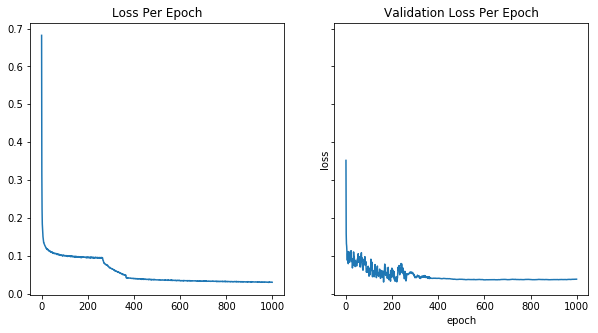

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5), sharey=True)
losses = results.results['losses']
epochs = np.arange(len(losses))
ax1.set_title('Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
ax1.plot(epochs, losses) #plt.subplot(122)
val_losses = results.results['validation_losses']
epochs = np.arange(len(val_losses))
plt.title(r'Validation Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
ax2.plot(epochs, val_losses)
plt.show()


from sklearn.preprocessing import minmax_scale
metric = minmax_scale(results.results['metric_per_epoch'], feature_range=(0,1))
epochs = np.arange(len(losses)) * 15
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, metric)

val_losses = minmax_scale(results.results['validation_losses'], feature_range=(0,1))
epochs = np.arange(len(val_losses))
plt.title(r'Early stopping evaluation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, val_losses)

plt.legend(["metric", "val_loss"])
plt.show()

In [17]:
results.results['eval_summary']

{'mean_rank': None,
 'hits@k': None,
 'precision': None,
 'recall': None,
 'accuracy': None,
 'f1_score': None}

## Load and evaluate

In [1]:
import torch
import json
import os
import pykeen.constants as pkc
from pykeen.kge_models import get_kge_model
from pykeen.utilities.pipeline import Pipeline

In [2]:
model_dir = '../../../models/'
models = os.listdir(model_dir)
models

['FB15k237_region_20191024-1703_dim50_sphere_rad0_regL0_lr001_loss-MRL_margin0.5_negfactor1_epochs1000_esmetric-custom_bs8192',
 'region_FB15k_20191024-1326_dim50_sphere_rad0_regL0_lr001_loss-MRL_margin0.5_negfactor1_epochs1000_esmetric-custom_bs8192',
 'region_FB15k_20191024-1328_dim50_sphere_rad0_regL0_lr001_loss-MRL_margin0.5_negfactor1_epochs1000_esmetric-custom_bs8192',
 'test',
 'region_FB15k_dim50_sphere_rad0_regL0_lr01_loss-MRL_margin0.5_negfactor1_epochs5_esmetric-custom_final',
 'region_FB15k_20191023-1742_dim50_sphere_rad0_regL0_lr001_loss-BPR_margin0.5_negfactor1_epochs1000_esmetric-custom_bs8192',
 'FB15k237_TransE_20191024-17 3_dim50_loss-MRL_lr001_margin1_epochs1000_bs8192_esmetric-custom',
 'region_FB15k_20191023_dim50_sphere_rad0_regL0_lr001_loss-BPR_margin0.5_negfactor1_epochs1000_esmetric-custom_final',
 'FB15k237_TransE_20191024-1716_dim50_loss-MRL_lr001_margin1_epochs1000_bs8192_esmetric-custom',
 'region_FB15k_20191023_dim50_sphere_rad0_regL0_lr001_loss-BPR_margin

In [3]:
model_path = 'FB15k237_TransE_20191024-1716_dim50_loss-MRL_lr001_margin1_epochs1000_bs8192_esmetric-custom'
if model_path:
    input_directory = os.path.join(model_dir, model_path)
    results = {
    'losses': json.load(open(os.path.join(input_directory, 'losses.json'))),
    'validation_losses': json.load(open(os.path.join(input_directory, 'val_losses.json'))),
    'entity_to_embedding': json.load(open(os.path.join(input_directory, 'entities_to_embeddings.json'))),
    'relation_to_embedding': json.load(open(os.path.join(input_directory, 'relations_to_embeddings.json'))),
    'final_configuration': json.load(open(os.path.join(input_directory, 'configuration.json'))),
    'eval_summary': json.load(open(os.path.join(input_directory, 'evaluation_summary.json'))),
    'entity_to_id': json.load(open(os.path.join(input_directory, 'entity_to_id.json'))),
    'relation_to_id': json.load(open(os.path.join(input_directory, 'relation_to_id.json')))
    }
    # Initialize KG embedding model
    config = results['final_configuration']
    config['training_set_path'] = '../../../data/fb15k-237/train.tsv'
    config['test_set_path'] = '../../../data/fb15k-237/valid.tsv'
    relation_to_id = results['relation_to_id']
    entity_to_id = results['entity_to_id']
else:
    # Initialize KG embedding model
    input_directory = output_directory
    config[pkc.NUM_ENTITIES] = 14541
    config[pkc.NUM_RELATIONS] = 237
    config[pkc.PREFERRED_DEVICE] = 'gpu1'
    relation_to_id = json.load(open(os.path.join(input_directory, 'relation_to_id.json'),'r'))
    entity_to_id = json.load(open(os.path.join(input_directory, 'entity_to_id.json'),'r'))

Get evaluation results:
 * Mean rank
 * Hits@k, k $\in$ {1,3,5,10} 

In [4]:
pipeline = Pipeline(config)
config[pkc.PREFERRED_DEVICE] = pipeline.device_name
if config['random_seed'] is not None:
    torch.manual_seed(config['random_seed'])
pipeline.entity_label_to_id = entity_to_id
pipeline.relation_label_to_id = relation_to_id
    
model: torch.nn.Module = get_kge_model(config=config)
model.load_state_dict(torch.load(os.path.join(input_directory, 'best_model.pkl')))

#results['trained_model'] = model 
type(model)

/mounts/Users/student/speranskaya/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


pykeen.kge_models.trans_e.TransE

In [5]:
metrics =[pkc.MEAN_RANK, pkc.HITS_AT_K] #  [pkc.MEAN_RANK, pkc.HITS_AT_K, pkc.TRIPLE_PREDICTION]

#### Evaluate RelationalTriple

In [12]:
val_results = pipeline.evaluate(
    model, 
    '../../../data/fb15k-237/valid.tsv', 
    #neg_test_path = '../../../data/fb15k-237/valid_neg.tsv', 
    metrics=metrics,
    filter_neg_triples=True,
    threshold_search=True,
    single_threshold=False
)

In [13]:
val_results['eval_summary']

{'mean_rank': 0.23449383249349431,
 'hits@k': {1: 0.15680068434559452,
  3: 0.25449101796407186,
  5: 0.3079840319361277,
  10: 0.39250071285999427},
 'precision': None,
 'recall': None,
 'accuracy': None,
 'f1_score': None}

In [ ]:
val_results_ = pipeline.evaluate(
    model, 
    '../../../data/fb15k/valid.tsv', 
    neg_test_path = '../../../data/fb15k/valid_neg.tsv', 
    metrics=['prediction'],
    threshold_search=True,
    single_threshold=True
)

In [ ]:
val_results['eval_summary']

In [ ]:
model.relation_thresholds.tolist()

In [ ]:
test_results = pipeline.evaluate(
    model, 
    '../../../data/fb15k/test.tsv', 
    neg_test_path = '../../../data/fb15k/test_neg.tsv',
    metrics= metrics,
    threshold_search=False
)

In [ ]:
test_results['eval_summary']

In [14]:
json.dump(val_results['eval_summary'], open(os.path.join(input_directory, 'valid_evaluation_summary.json'),"w"))

In [ ]:
json.dump(test_results['eval_summary'], open(os.path.join(input_directory, 'evaluation_summary.json'),"w"))

## Load results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [ ]:
%matplotlib inline

In [ ]:
model_dir = '../../../models/'
models = os.listdir(model_dir)
models

In [ ]:
#output_directory = '../../../models/region_hpo/'
model_path = 'region_FB15k_20191023_dim50_sphere_rad0_regL0_lr001_loss-BPR_margin0.5_negfactor1_epochs1000_esmetric-custom'
input_directory = os.path.join(model_dir, model_path)


results = {
    'losses': json.load(open(os.path.join(input_directory, 'losses.json'))),
    'validation_losses': json.load(open(os.path.join(input_directory, 'val_losses.json'))),
    'entity_to_embedding': json.load(open(os.path.join(input_directory, 'entities_to_embeddings.json'))),
    'relation_to_embedding': json.load(open(os.path.join(input_directory, 'relations_to_embeddings.json'))),
    'final_configuration': json.load(open(os.path.join(input_directory, 'configuration.json'))),
    'eval_summary': json.load(open(os.path.join(input_directory, 'evaluation_summary.json'))),
    'entity_to_id': json.load(open(os.path.join(input_directory, 'entity_to_id.json'))),
    'relation_to_id': json.load(open(os.path.join(input_directory, 'relation_to_id.json')))
}

In [ ]:
results.keys()

In [ ]:
results['final_configuration']

In [ ]:
losses = results['losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

In [ ]:
losses[-1]

In [ ]:
losses = results['validation_losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

In [ ]:
losses[-1]

In [ ]:
results['eval_summary']